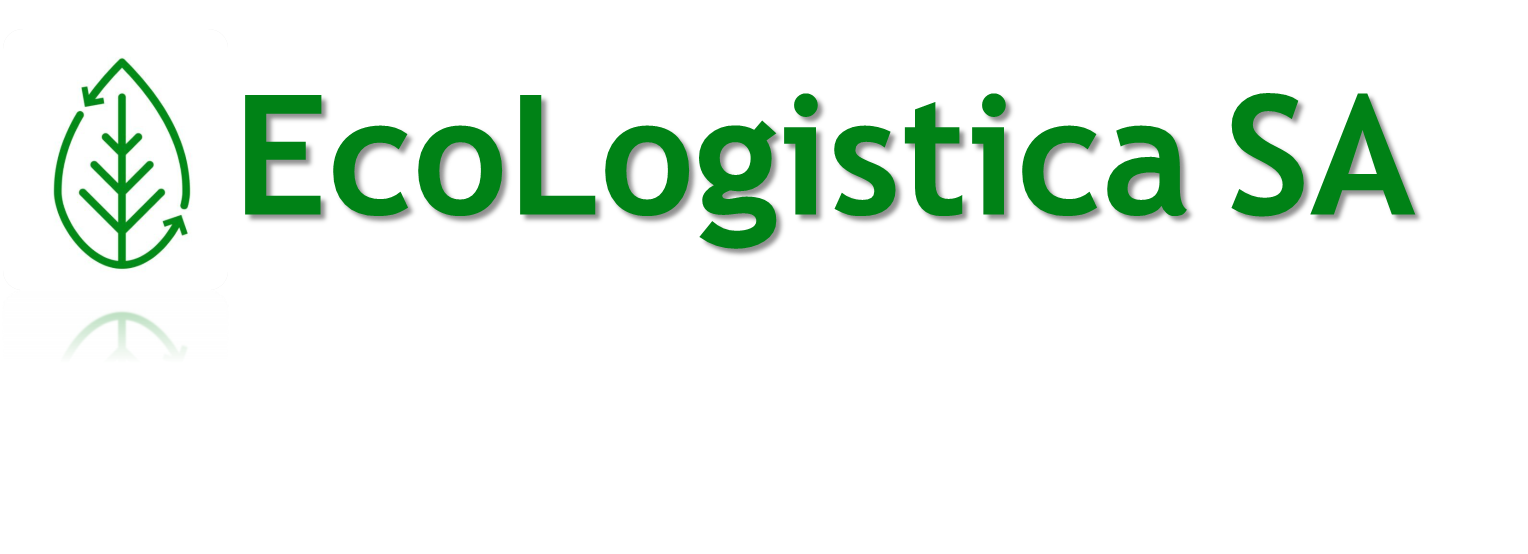

#  <span style="color:rgb(50,100,100);"><strong>&#128304; Desafío entregable #15: Desafío_CrossValidation &#128304;</strong></span>

## ⏩ **<u>CrossValidation </u>** 

### El problema: predecir precio de venta de los envios a la provincia de Salta y costo de un paquete segun peso, provincia y cp destino 

Importamos librerias.

In [48]:
# Importaciones comunes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings;
import seaborn as sns
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error


In [2]:
ruta='F:\\Proyecto\\Proyecto_Coder_DS\\set de datos\\archivo_final.csv'
dfxx = pd.read_csv(ruta, delimiter='|',parse_dates=["fecha"])

Ahora vamos a hacer un pequeño filtrado de los datos. Si bien vimos que la exploración de los datos y su preprocesamiento es una parte muy importante del proceso, no nos vamos a meter aquí con eso.

## **Identificación y filtrado de valores atípicos en datos financieros**

            seleccionamos las columnas relevantes del conjunto de datos, como 'margen_ganancia_USD', 'precio_USD' y 'total_costo_USD'. A continuación, se calculan los valores del primer cuartil (Q1), el tercer cuartil (Q3) y el IQR utilizando la función quantile().

Una vez obtenidos estos valores, es posible filtrar los valores atípicos utilizando un enfoque basado en el rango intercuartil. Aquellas observaciones que se encuentren por debajo de Q1 - 1.5 * IQR o por encima de Q3 + 1.5 * IQR se considerarán valores atípicos y podrán ser separados en un DataFrame aparte para su posterior análisis.

In [3]:
# Seleccionar las columnas 'margen_ganancia_USD', 'precio' y 'total_costo'
columns = ['precio', 'total_costo','peso','bultos']
Q1 = dfxx[columns].quantile(0.25)
Q3 = dfxx[columns].quantile(0.98)
IQR = Q3 - Q1

dfxx_sin_outliers = dfxx[~((dfxx[columns] < (Q1 - 1.5 * IQR)) | (dfxx[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
dfxx_solo_outliers = dfxx[((dfxx[columns] < (Q1 - 1.5 * IQR)) | (dfxx[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [4]:
max_values = dfxx_sin_outliers[['precio', 'total_costo', 'peso','bultos']].max()
max_values_rounded = max_values.apply(lambda x: round(x, 2))
display(max_values_rounded)

precio         7766.70
total_costo    2451.22
peso             39.14
bultos            6.00
dtype: float64

In [5]:
#Seleccionamos las variables a procesar.
data=dfxx_sin_outliers[['precio_USD','total_costo_USD','provincia_destino','cp_destino','cp_origen','peso','bultos']].copy()
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2132917 entries, 0 to 2168796
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   precio_USD         float64
 1   total_costo_USD    float64
 2   provincia_destino  object 
 3   cp_destino         int64  
 4   cp_origen          int64  
 5   peso               float64
 6   bultos             int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 130.2+ MB


None

In [6]:
#FLITRAMOS LOS DATOS QUE CORRESPONDEN A LOS ENVIOS CON DESTINO SALTA
data_salta = data[data['provincia_destino'] == 'SALTA'].copy()

Hagamos una breve exploración de los datos:

In [7]:
data_salta.head()

,precio_USD,total_costo_USD,provincia_destino,cp_destino,cp_origen,peso,bultos
30,0.000952,2.110794,SALTA,4400,1000,0.5,1
1444,0.000317,1.510952,SALTA,4400,1072,0.2,1
1499,2.380952,0.000000,SALTA,4400,1005,1.0,1
1500,2.380952,0.000000,SALTA,4400,1005,1.0,1
1501,2.380952,0.000000,SALTA,4400,1005,1.0,1


In [8]:
data_salta.shape

(6751, 7)

validamos si hay nulos y remplazamos de ser asi con el promedio

In [9]:
display(data_salta.isnull().sum())

precio_USD            0
total_costo_USD       0
provincia_destino     0
cp_destino            0
cp_origen             0
peso                 73
bultos                0
dtype: int64

In [10]:
promedio_peso = round(data_salta['peso'].mean(), 2)
data_salta['peso'].fillna(promedio_peso, inplace=True)

In [11]:
display(data_salta.isnull().sum())

precio_USD           0
total_costo_USD      0
provincia_destino    0
cp_destino           0
cp_origen            0
peso                 0
bultos               0
dtype: int64

Ahora qeu no hay mas nulos podemos comenzar con el desafio.

Antes que nada hacemos un LabelEncoder a las columnas categoricas. 

In [12]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['provincia_destino']
le = LabelEncoder()

for column in categorical_columns:
    data_salta[column] = le.fit_transform(data_salta[column])
data_salta.head()

,precio_USD,total_costo_USD,provincia_destino,cp_destino,cp_origen,peso,bultos
30,0.000952,2.110794,0,4400,1000,0.5,1
1444,0.000317,1.510952,0,4400,1072,0.2,1
1499,2.380952,0.000000,0,4400,1005,1.0,1
1500,2.380952,0.000000,0,4400,1005,1.0,1
1501,2.380952,0.000000,0,4400,1005,1.0,1


In [13]:
# Eliminar filas con valores cero en las columnas 'precio' y 'peso'
data_salta = data_salta[(data_salta['precio_USD'] != 0) & (data_salta['peso'] != 0)]

# Verificar la nueva forma del DataFrame
print(data_salta.shape)

(6597, 7)


<function matplotlib.pyplot.show(close=None, block=None)>

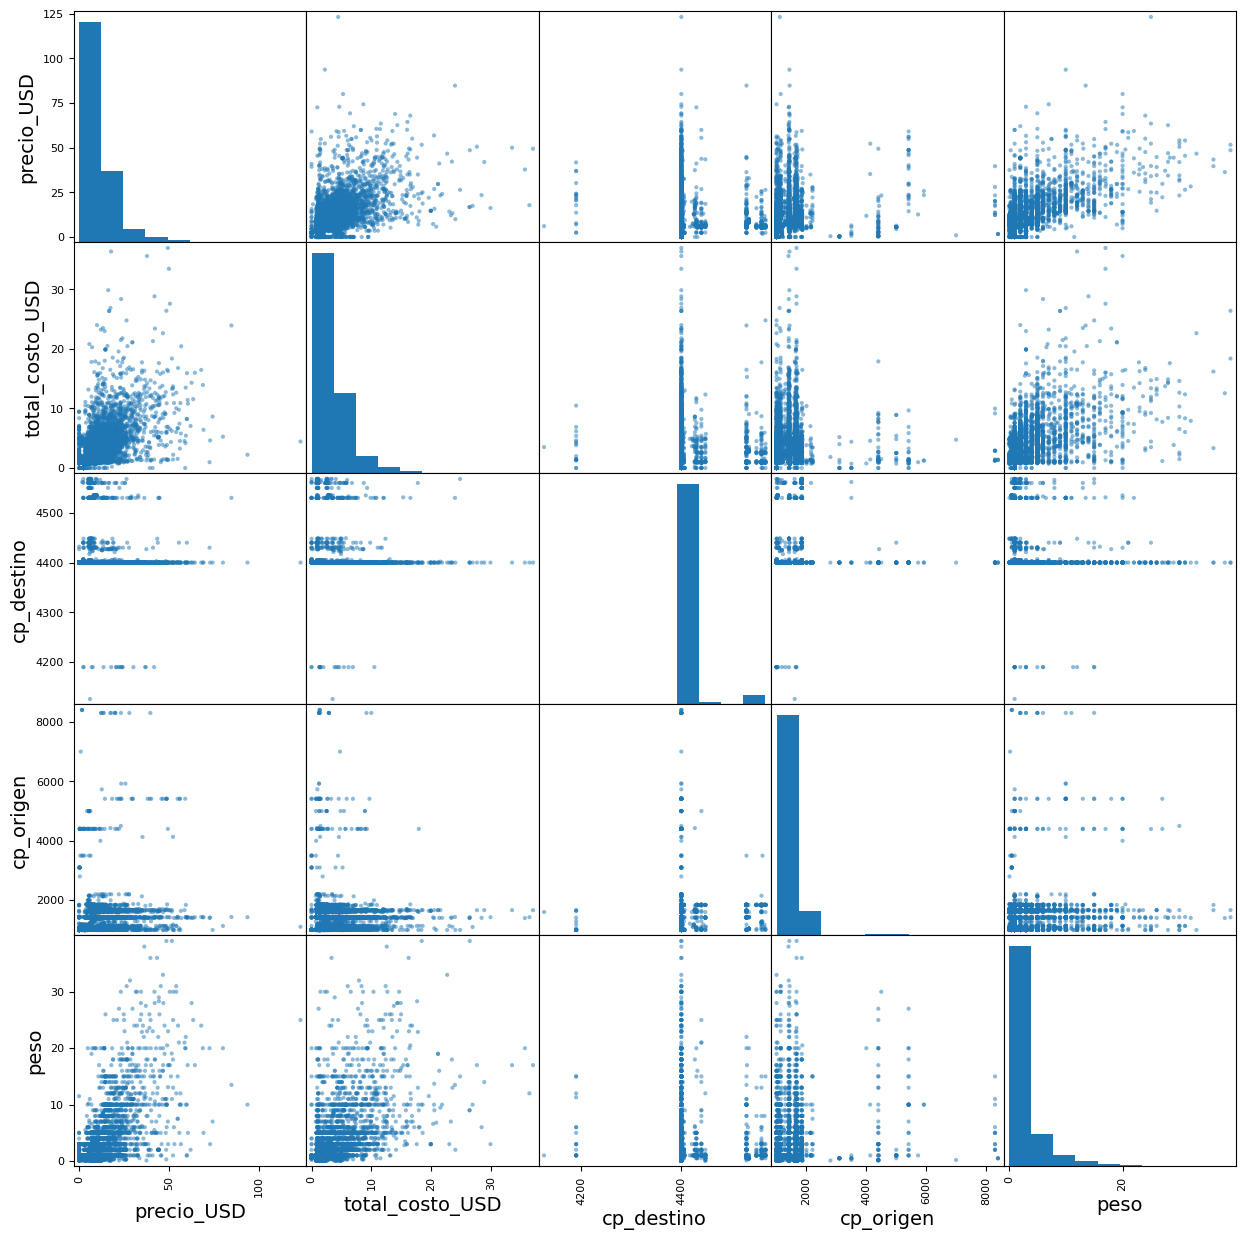

In [14]:
#sample_data = data_salta.sample(n=5000)  # Toma una muestra aleatoria de 500000 filas
pd.plotting.scatter_matrix(data_salta[['precio_USD','total_costo_USD','cp_destino','cp_origen','peso']], figsize=(15, 15), alpha=0.5)
plt.show

In [15]:
correlation_matrix = data_salta[['precio_USD','total_costo_USD','cp_destino','cp_origen','peso']].corr()
correlation_matrix

,precio_USD,total_costo_USD,cp_destino,cp_origen,peso
precio_USD,1.000000,0.568732,-0.039378,0.170546,0.629347
total_costo_USD,0.568732,1.000000,-0.027118,0.058531,0.524195
cp_destino,-0.039378,-0.027118,1.000000,0.087769,-0.024240
cp_origen,0.170546,0.058531,0.087769,1.000000,0.136012
peso,0.629347,0.524195,-0.024240,0.136012,1.000000


Precio vs. Peso: Existe una correlación positiva moderada de 0.629347 entre el precio en USD y el peso. Esto sugiere que a medida que el peso aumenta, es probable que el precio en USD también aumente. Esta relación se evidencia en la matriz de correlación y se refuerza al observar la gráfica de dispersión correspondiente. Es posible que los productos más pesados requieran más recursos o tengan mayores costos asociados, lo que se refleja en un precio más alto.

Precio vs. Cp_destino: La correlación entre el precio en USD y el código postal de destino (-0.039378) es muy débil y casi nula. Esto indica que no hay una relación clara o significativa entre estas dos variables. al realizar un análisis adicional, se puede observar una mayor concurrencia de códigos postales correspondientes a la localidad de Salta que comienzan con "4400". Sin embargoimpacto directo en el precio en USD de los productos.


Comencemos con la usual separación entre conjuntos de entrenamiento y testeo:

In [16]:
# Separa Train y Test
from sklearn.model_selection import train_test_split

x_train, x_test, t_train, t_test = train_test_split(data_salta[['precio_USD','total_costo_USD','cp_destino','cp_origen','peso']], data_salta['precio_USD'], random_state=42)

## **Implementación**

Definamos una función para construir la regresión de _Ridge_. En este caso va a ser recomendable usar el StandardScaler para estandarizar nuestros datos, pues tienen unidades distintas no comparables.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import Ridge

def ridge(m, ll):
    """
    Construye un pipeline para la regresión contraída (ridge regression)
    usamos un StandardScaler

    :param int m: grado del polinomio de las características
    :param float ll: coeficiente de regularización lambda

    Atención: la función ridge toma como argumento alpha = lambda/2
    """
    return Pipeline([('scaler', StandardScaler()),
                     ('poly_features', PolynomialFeatures(degree=m)),
                     ('regressor', Ridge(fit_intercept=False, alpha=ll/2))])

Ahora pasemos sobre todos los $M$ (grados) y $\lambda$ (valor del regularizador), y evaluemos en el conjunto:

In [18]:
from sklearn.metrics import mean_squared_error

# El espacio de búsqueda de lambdas tiene forma logarítmica
lambdas = [0.1, 1, 10, 100, 1000]

# Espacio de búsqueda de grados va de 1 a 6.
grados = [1, 2, 3, 4, 5, 6]

# En esta lista voy a ir guardando los MSE en el conjunto de test
errores_test = []

# Iteramos sobre todos los valores y los guardamos todos
# Esto es principalmente porque nos interesa en esta etapa entender el espacio de hiperparámetros
# En algunos casos, por tema de memoria y/o performance, es interesante solo mantener los mejores-k
for ll in lambdas:
    for m in grados:
        # Creo modelo
        rr = ridge(m, ll)
        # Lo ajusto al conjunto de entrenamiento
        rr.fit(x_train, t_train)

        # Calculamos el MSE en test y lo agregamos a la lista de errores
        errores = mean_squared_error(t_test, rr.predict(x_test))
        errores_test.append(errores)

# Redimensiono los errores en una matriz (para después visualizarlos)
errores_test = np.array(errores_test).reshape((len(lambdas), len(grados)))
errores_test

array([[2.86947413e-08, 5.59352954e-08, 9.98802601e-08, 6.52142663e-07,
        2.23426283e-02, 3.90920411e+00],
       [2.86847730e-06, 5.58887970e-06, 9.97094800e-06, 6.09118662e-05,
        3.27711255e-01, 4.16768821e+00],
       [2.85854384e-04, 5.54278755e-04, 9.80369281e-04, 3.96023841e-03,
        5.33107092e-01, 1.59113488e+01],
       [2.76257728e-02, 5.11923967e-02, 8.41895400e-02, 1.82415261e-01,
        1.13436653e+00, 2.18375621e+01],
       [2.05250010e+00, 2.86816563e+00, 3.61877636e+00, 4.59127747e+00,
        1.35329629e+01, 9.19612170e+00]])

In [19]:
# Tomo raiz cuadrada del MSE
errores_test_milusd = np.sqrt(errores_test)
display(errores_test_milusd)

array([[1.69395222e-04, 2.36506438e-04, 3.16038384e-04, 8.07553505e-04,
        1.49474507e-01, 1.97717073e+00],
       [1.69365796e-03, 2.36408115e-03, 3.15768079e-03, 7.80460545e-03,
        5.72460702e-01, 2.04149166e+00],
       [1.69072288e-02, 2.35431254e-02, 3.13108493e-02, 6.29304251e-02,
        7.30141830e-01, 3.98890321e+00],
       [1.66210026e-01, 2.26257368e-01, 2.90154338e-01, 4.27100996e-01,
        1.06506645e+00, 4.67306774e+00],
       [1.43265491e+00, 1.69356595e+00, 1.90230817e+00, 2.14272664e+00,
        3.67871756e+00, 3.03251079e+00]])

Basándonos en los resultados de los errores cuadráticos medios (MSE) obtenidos en la matriz, podemos hacer las siguientes observaciones:

            *En general, los valores de MSE son relativamente altos, lo que indica que el modelo de regresión Ridge no se ajusta muy bien a los datos en este caso.
            *A medida que el grado del polinomio aumenta, los valores de MSE tienden a aumentar gradualmente. Esto sugiere que modelos con grados más altos tienden a tener un rendimiento inferior en la predicción del precio en USD.
            *La variación en los valores de MSE entre diferentes coeficientes de regularización lambda es menor. Esto podría indicar que la regularización no está influyendo significativamente en el rendimiento del modelo en este caso particular.
            *Los valores de MSE más bajos se encuentran en la fila correspondiente al grado 2 y en la columna correspondiente al coeficiente de regularización lambda 0.1. Esto sugiere que este conjunto de hiperparámetros puede ser una opción razonable para obtener un rendimiento relativamente mejor.

Hacemos una gráfica del MSE como función de $M$ y $\lambda$ como una imagen. Aquí usamos la función `plt.pcolor`.

Text(0, 0.5, 'Regularizador ($\\lambda$)')

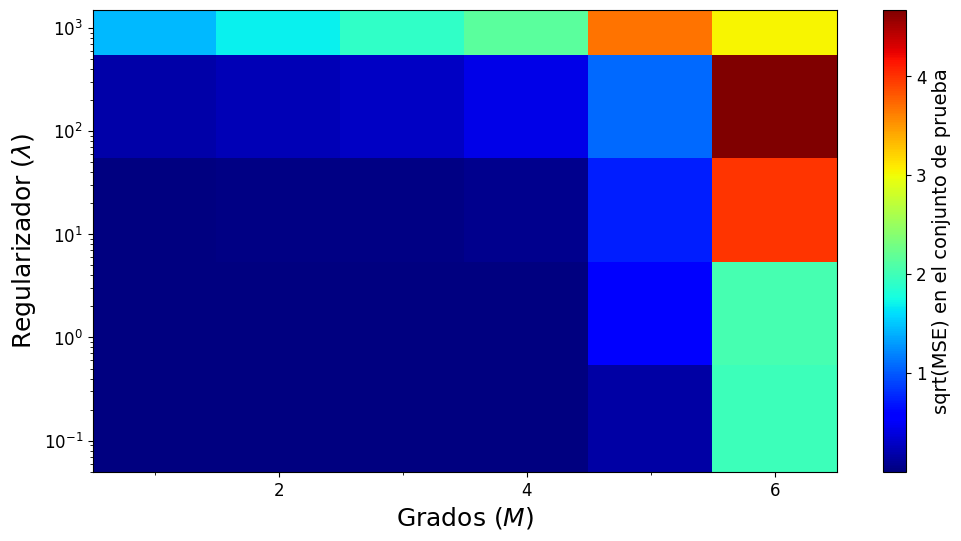

In [20]:
# Valores de los ejes
Xp, Yp = np.meshgrid(grados, lambdas)
Zp = errores_test_milusd

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
# Grafico
pcol = plt.pcolor(Xp, Yp, Zp, cmap='jet')

# Usamos escala logarítmica para lambda
ax.set_yscale('log')
ax.set_ylim(0.05,1500)

# Define las marcas del eje x en números enteros
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

# Barra de colores y rótulos
plt.colorbar(pcol, label='sqrt(MSE) en el conjunto de prueba')
ax.set_xlabel('Grados ($M$)', fontsize=18)
ax.set_ylabel('Regularizador ($\lambda$)', fontsize=18)

Veamos cual es la posición del mínimo

In [21]:
position = np.argmin(Zp)

mejor_grado = Xp.flatten()[position]
mejor_lambda = Yp.flatten()[position]
mejor_MSE = errores_test.flatten()[position]

print("M = {}".format(mejor_grado))
print("Lambda = {:.2e}".format(mejor_lambda))
print("Lambda =", mejor_lambda)
print("MSE = {}".format(mejor_MSE))

M = 1
Lambda = 1.00e-01
Lambda = 0.1
MSE = 2.8694741321880014e-08


En el resultado que has proporcionado, se muestra que el mejor grado es 1, el valor de regularización es 1.00e-01 (también mostrado como 0.1) y el MSE correspondiente a esta combinación es 2.8694741321880014e-08.

Estos resultados indican la configuración óptima de grado y regularización que produce el MSE más bajo en el conjunto de prueba según el modelo de regresión Ridge utilizado en el código anterior.

Para poder objetivamente asegurarnos la performance de nuestro modelo (sobre todo en el caso en que no conocemos la distribución real) en  **datos nuevos nunca vistos** debemos limitarnos y no mirar el conjunto de test. De otra manera sobreajustaremos al conjunto de test y no nos servirá como estimador de la performance real.

* Conjunto de Entrenamiento/Train: donde ajustamos el modelo.
* Conjunto de Validación: Donde evaluamos el modelo y lo usamos para escoger mejores hiperparámetros/características etc.
* Conjunto de Prueba/Test: Lo usamos solamente **al final** del desarrollo para establecer la performance esperada del modelo en datos nuevos.

In [22]:
#Corte de train test y validación

# Primero separamos el test
from sklearn.model_selection import train_test_split
x_train_full, x_test, t_train_full, t_test = train_test_split(data_salta[['precio_USD','total_costo_USD','cp_destino','cp_origen','peso']], data_salta['precio_USD'], random_state=42)

# Segundo, separamos el conjunto de validación
x_train, x_val, t_train, t_val = train_test_split(x_train_full, t_train_full, random_state=42)

Corremos las mismas rondas que antes pero ahora evaluando en validación.

In [23]:
# El espacio de búsqueda de lambdas tiene forma logarítmica
lambdas = [0.1, 1, 10, 100, 1000]

# Espacio de búsqueda de grados va de 1 a 6.
grados = [1, 2, 3, 4, 5, 6]

# En esta lista voy a ir guardando los MSE
errores_validacion = []

for ll in lambdas:
    for m in grados:
        # Creo modelo
        rr = ridge(m, ll)
        # Lo ajusto al conjunto de entrenamiento
        rr.fit(x_train, t_train)

        # Calculamos el MSE en validacion y lo agregamos a la lista de errores
        errores = mean_squared_error(t_val, rr.predict(x_val))
        errores_validacion.append(errores)

# Redimensiono los errores en una matriz (para después visualizarlos)
errores_validacion = np.array(errores_validacion).reshape((len(lambdas), len(grados)))
errores_validacion

array([[5.49552987e-08, 1.91879133e-07, 5.14115774e-07, 1.19572675e-05,
        8.00246412e-03, 2.26749120e+00],
       [5.49297686e-06, 1.91667966e-05, 5.13164272e-05, 1.03987976e-03,
        3.43483396e-01, 6.23930950e+01],
       [5.46756468e-04, 1.89579730e-03, 5.03773248e-03, 7.46563550e-02,
        2.50750062e+01, 1.69788509e+03],
       [5.22472188e-02, 1.70803079e-01, 4.21347588e-01, 6.46100447e+00,
        1.12946955e+03, 2.94076243e+03],
       [3.56805207e+00, 8.18928997e+00, 1.11737651e+01, 2.21893366e+02,
        9.08375985e+03, 2.80747886e+04]])

Ahora podemos elegir los mejores hipérparametros usando la performance en set de validación.

In [24]:
position = np.argmin(errores_validacion)

mejor_grado_val = grados[position%len(grados)]
mejor_lambda_val = lambdas[position//len(lambdas)]
mejor_MES_val = errores_validacion.flatten()[position]

print("Grado (M) = {}".format(mejor_grado_val))
print("Lambda = {:.2e}".format(mejor_lambda_val))
print("Lambda =", mejor_lambda)
print("MSE = {:.2f}".format(mejor_MES_val))

Grado (M) = 1
Lambda = 1.00e-01
Lambda = 0.1
MSE = 0.00


Se muestra que el mejor grado es 1, el valor de regularización es 1.00e-01 (también mostrado como 0.1) y el MSE correspondiente a esta combinación es 0.00.

Estos resultados indican la configuración óptima de grado y regularización que produce el MSE más bajo en el conjunto de validación según el modelo de regresión Ridge utilizado en el código anterior.

Y ahora usamos el dataset de test para ver la generalización a datos nuevos. Vamos a usar los hiperparámetros que acabamos de determinar con la validación:

In [25]:
# Primero instanciamos el modelo
mejor_ridge_val = ridge(mejor_grado_val, mejor_lambda_val)

# Luego entrenamos
mejor_ridge_val.fit(x_train_full, t_train_full)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_features', PolynomialFeatures(degree=1)),
                ('regressor', Ridge(alpha=0.05, fit_intercept=False))])

Y evaluamos el MSE en el conjunto de testeo

In [26]:
y_test = mejor_ridge_val.predict(x_test)
print('Error de TEST final: {:.2f}'.format(mean_squared_error(t_test, y_test)))

Error de TEST final: 0.00


Después de haber encontrado los _mejores_ hiperparámetros, se puede hacer un modelo final entrenando con toda la data.

In [27]:
mejor_ridge_val = ridge(mejor_grado_val, mejor_lambda_val)
mejor_ridge_val.fit(x_train_full, t_train_full)

y_test = mejor_ridge_val.predict(x_test)
MSE_mejor_val = mean_squared_error(t_test, y_test)
print('Error de TEST final: {:.2f}'.format(MSE_mejor_val))

Error de TEST final: 0.00


## Validación cruzada con K-Folding

Para resolver el problema anterior usamos _Validación Cruzada_. Consiste en entrenar sobre distintos cortes de entrenamiento y validación. De esta manera conseguimos una muestra de la distribución de performance de los hiperparámetros de distintos datasets. Entonces, podemos computar la varianza y la media de la performance, y elegir así el mejor hiperparámetro

In [28]:
from sklearn.model_selection import cross_val_score

In [29]:
model = ridge(mejor_grado_val, mejor_lambda_val)

scores = cross_val_score(model, x_train_full, t_train_full, cv=5, scoring='neg_mean_squared_error')
-scores

array([5.98619529e-08, 4.35470085e-08, 4.30123412e-08, 4.45911429e-08,
       3.93809841e-08])

In [30]:
print(-scores.mean())
print(scores.std())

4.607868593837163e-08
7.111431675336049e-09


El modelo de regresión utilizado tiene un error promedio de alrededor de 4.60 en la predicción del precio en USD y una variabilidad de aproximadamente 7.11 en los errores a través de los diferentes folds.

Analiza si hay otras características relevantes que puedan influir en el precio y que no se hayan incluido en el modelo. 

Veamos ahora qué ocurre cuando hacemos una búsqueda en todo el espacio.

In [31]:
# El espacio de búsqueda de lambdas tiene forma logarítmica
lambdas = [0.1, 1, 10, 100, 1000]

# Espacio de búsqueda de grados va de 1 a 6.
grados = [1, 2, 3, 4, 5, 6]

cv_errors = []
cv_std = []

for ll in lambdas:
    for m in grados:
        # Crea el modelo

        rr = ridge(m, ll)

        scores = cross_val_score(rr, x_train_full, t_train_full, cv=5, scoring='neg_mean_squared_error')

        cv_errors.append(-scores.mean())
        cv_std.append(scores.std())

cv_errors = np.array(cv_errors).reshape((len(lambdas), len(grados)))
cv_std = np.array(cv_std).reshape((len(lambdas), len(grados)))

Text(0, 0.5, 'Regularizador ($\\lambda$)')

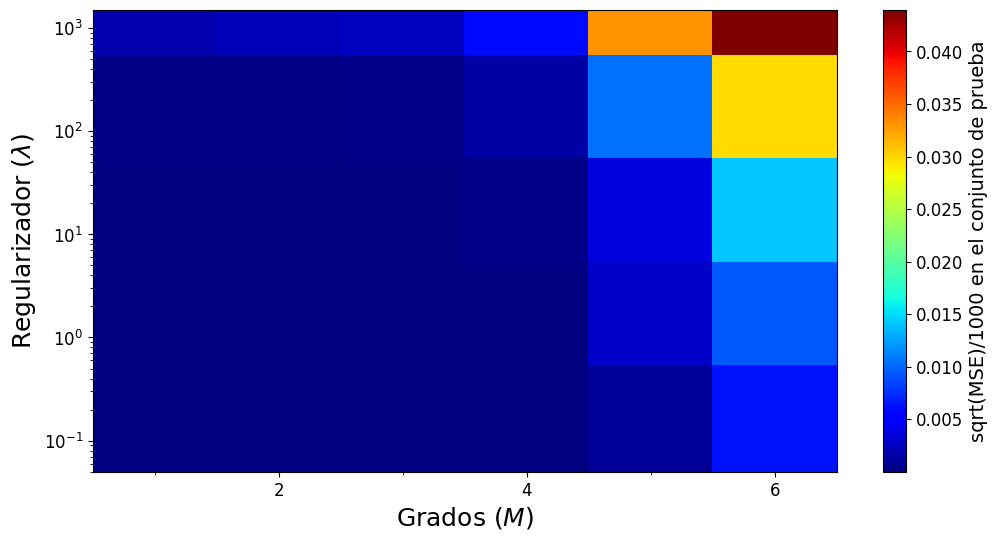

In [32]:
# Valores de los ejes
Xp, Yp = np.meshgrid(grados, lambdas)
errores_cv_milusd = np.sqrt(cv_errors)/1000 # Expreso el errores en miles de usd
Zp = errores_cv_milusd

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
# Grafico
pcol = plt.pcolor(Xp, Yp, Zp, cmap='jet')

# Usamos escala logarítmica para lambda
ax.set_yscale('log')
ax.set_ylim(0.05,1500)

# Define las marcas del eje x en números enteros
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

# Barra de colores y rótulos
plt.colorbar(pcol, label='sqrt(MSE)/1000 en el conjunto de prueba')
ax.set_xlabel('Grados ($M$)', fontsize=18)
ax.set_ylabel('Regularizador ($\lambda$)', fontsize=18)

In [33]:
position = np.argmin(cv_errors)

mejor_grado_cv = grados[position%len(grados)]
mejor_lambda_cv = lambdas[position//len(lambdas)]
MES_cv = cv_errors.flatten()[position]

print("Grado (M) = {}".format(mejor_grado_cv))
print("Lambda = {:.2e}".format(mejor_lambda_cv))
print("Lambda =", mejor_lambda)
print("MSE = {:.2f}".format(MES_cv))
print("Std(MSE) = {:.2f}".format(cv_std.flatten()[position]))

Grado (M) = 1
Lambda = 1.00e-01
Lambda = 0.1
MSE = 0.00
Std(MSE) = 0.00


In [34]:
mejor_ridge_cv = ridge(mejor_grado_cv, mejor_lambda_cv)
mejor_ridge_cv.fit(x_train_full, t_train_full)

y_test = mejor_ridge_cv.predict(x_test)
MSE_mejor_cv = mean_squared_error(t_test, y_test)
print('Error final TEST: {:.2f}'.format(MSE_mejor_cv))

Error final TEST: 0.00


## **GridSearchCV**

In [35]:
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import LinearRegression, Ridge

model = Pipeline([('scaler', StandardScaler()),
    ('polynomial', PolynomialFeatures()),
    ('regressor', Ridge(fit_intercept=False) )
])

# Definimos los parámetros para cada parte del pipeline. Separamos parámetro de nombre con  ‘__’:
parameters = {'polynomial__degree' : range(1, 10),
              'regressor__alpha': np.logspace(-2, 4, 20)}


grid_search = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

Ahora corremos `fit` para saber cuáles son los mejore hiperparámetros.

In [36]:
grid_search.fit(x_train_full, t_train_full)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial', PolynomialFeatures()),
                                       ('regressor',
                                        Ridge(fit_intercept=False))]),
             n_jobs=-1,
             param_grid={'polynomial__degree': range(1, 10),
                         'regressor__alpha': array([1.00000000e-02, 2.06913808e-02, 4.28133240e-02, 8.85866790e-02,
       1.83298071e-01, 3.79269019e-01, 7.84759970e-01, 1.62377674e+00,
       3.35981829e+00, 6.95192796e+00, 1.43844989e+01, 2.97635144e+01,
       6.15848211e+01, 1.27427499e+02, 2.63665090e+02, 5.45559478e+02,
       1.12883789e+03, 2.33572147e+03, 4.83293024e+03, 1.00000000e+04])},
             scoring='neg_mean_squared_error')

Los mejores hiperparámetros son:

In [37]:
grid_search.best_params_

{'polynomial__degree': 1, 'regressor__alpha': 0.01}

El score (-MSE) es

In [38]:
grid_search.best_score_

-2.680538508812798e-09

Toda la información de la optimización

In [39]:
grid_search.cv_results_

{'mean_fit_time': array([5.98367055e-03, 5.65179189e-03, 5.65187136e-03, 5.98303477e-03,
        5.65179189e-03, 4.32244937e-03, 6.31650289e-03, 4.32260831e-03,
        4.98668353e-03, 7.31372833e-03, 4.32173411e-03, 4.32213147e-03,
        5.31872114e-03, 5.65123558e-03, 4.65408961e-03, 4.32157516e-03,
        4.65432803e-03, 4.98731931e-03, 4.65448697e-03, 3.99001439e-03,
        6.64933523e-03, 4.98668353e-03, 5.31919797e-03, 6.98081652e-03,
        1.19687716e-02, 5.65203031e-03, 6.64861997e-03, 5.98375003e-03,
        6.31602605e-03, 4.98692195e-03, 6.98169072e-03, 9.64117050e-03,
        6.64997101e-03, 7.97867775e-03, 5.32007217e-03, 6.31626447e-03,
        8.64434242e-03, 5.65147400e-03, 7.97883670e-03, 5.65099716e-03,
        1.49590969e-02, 8.31127167e-03, 7.31333097e-03, 7.64568647e-03,
        7.64608383e-03, 7.64536858e-03, 7.31356939e-03, 8.64330928e-03,
        8.30904643e-03, 9.64045525e-03, 8.64354769e-03, 7.97804197e-03,
        9.64037577e-03, 7.31452306e-03, 7.31396

podemos guardar los resultados del GridSearch en un DataFrame usando los diccionario que entrega el `grid_search.cv_results_`

In [40]:
cv_results = grid_search.cv_results_

In [41]:
# Armo el dataframe
results_df = pd.DataFrame(cv_results)

# Selecciono solo las columnas que me interesan
columnas = ['param_polynomial__degree', 'param_regressor__alpha',
            'mean_test_score', 'std_test_score']
results_df = results_df[columnas]

In [42]:
results_df.head(10)

,param_polynomial__degree,param_regressor__alpha,mean_test_score,std_test_score
0,1,0.01,-2.680539e-09,3.898050e-10
1,1,0.020691,-1.147613e-08,1.668848e-09
2,1,0.042813,-4.913183e-08,7.144562e-09
3,1,0.088587,-2.103382e-07,3.058533e-08
4,1,0.183298,-9.004259e-07,1.309201e-07
5,1,0.379269,-3.854121e-06,5.602841e-07
6,1,0.78476,-1.649279e-05,2.396739e-06
7,1,1.623777,-7.054051e-05,1.024335e-05
8,1,3.359818,-3.013836e-04,4.369733e-05
9,1,6.951928,-1.284830e-03,1.856958e-04


In [43]:
best_pr = grid_search.best_estimator_

In [44]:
best_pr

Pipeline(steps=[('scaler', StandardScaler()),
                ('polynomial', PolynomialFeatures(degree=1)),
                ('regressor', Ridge(alpha=0.01, fit_intercept=False))])

## **RandomizedSearchCV**

In [45]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import LinearRegression

polinomial_model = Pipeline([('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures()),
    ('regressor', Ridge(fit_intercept=False) )
])

# los parámetros se setean por nombre y parametro con ‘__’ :
parameters = {'poly_features__degree' : np.arange(1,20),
              # observé que usamos funciones de scipy para definir el espacio de búsqueda
              'regressor__alpha' : np.logspace(-2, 8, 100)}

random_search = RandomizedSearchCV(polinomial_model, parameters, n_iter=10, random_state=42, scoring='neg_mean_squared_error', cv=3)

In [49]:
random_search.fit(x_train_full, t_train_full)
random_search.best_params_, -random_search.best_score_

({'regressor__alpha': 1.3219411484660286, 'poly_features__degree': 2},
 0.0001124286743180701)